# Personal Information
Name: **Pijus Krisiukenas**

StudentID: **14456990**

Email: [**pijus.krisiukenas@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **19.03.2023**

Github: https://github.com/pijuskri/MPQUIC-meta-learning

# Data Context
<!---
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**
-->
For this project, 3 main datasets (with 2 domains) will be used to set up the testing enviroment and data to be sent over the network. First, two trace datasets are used to determine the key performance metrics (KPI) for 5g and LTE(4g) network interfaces. These metrics vary over time and will be used to simulate real world changes . The data was retrieved from [Beyond Throughput, The Next Generation: a 5G Dataset with Channel and Context Metrics](https://github.com/uccmisl/5Gdataset) and [Beyond throughput: a 4G LTE dataset with channel and context metrics](https://www.kaggle.com/datasets/aeryss/lte-).
The other dataset is a set of videos available in a format that is needed for MPEG-DASH adaptive video streaming. A single video called "Big Buck Bunny" is used. Data was retrieved from [ITEC-Datasets](https://dash.itec.aau.at/dash-dataset/)

# Data Description
<!---
**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)
-->

In [1]:
# Imports
import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
from directory_tree import display_tree
%matplotlib inline
plt.style.use('bmh')

## Data Loading
### Trace data
Trace data is presented in nested directories containing .csv files. The nested format is {4g/5g dataset}/{download type}/{mobility type}/{file}.csv. These can be loaded and concatinated into a single data frame. Extra data that is contained in the directory names is also included

In [2]:
display_tree('traces/',max_depth=3)

traces/
├── 4G-Dataset/
│   └── Download/
│       ├── bus/
│       ├── car/
│       ├── pedestrian/
│       ├── static/
│       └── train/
└── 5G-production-dataset/
    ├── .DS_Store
    ├── Amazon_Prime/
    │   ├── Driving/
    │   └── Static/
    ├── Download/
    │   ├── .DS_Store
    │   ├── Driving/
    │   └── Static/
    └── Netflix/
        ├── Driving/
        └── Static/


In [20]:
#parse time from files
def dateparse (time_str):
    element = datetime.datetime.strptime(time_str,"%Y.%m.%d_%H.%M.%S")
    return element

#below all subdirectories are searched for data files
root = 'traces/'
all_files = []
filetype = '.csv'
for (dir_path, dir_names, files) in os.walk(root):
    for file in files:
         if file.lower().endswith(filetype.lower()):
            paths= re.split(r"[/\\]", dir_path.lower())
            df = pd.read_csv(os.path.join(dir_path, file), parse_dates=['Timestamp'],
                             infer_datetime_format=True)
            
            #based on subdirectory, is the download a video or a file
            df['download_type'] = paths[2]
            
            #based on subdirectory, what type of mobility are the traces
            df['trace_mobility'] = paths[3] 
            
            df['TraceID'] = len(all_files) #each file is a separate trace
            all_files.append(df)
df_5g = pd.concat(all_files, ignore_index=True)
df_5g

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,...,TraceID,PINGAVG,PINGMIN,PINGMAX,PINGSTDEV,PINGLOSS,CELLHEX,NODEHEX,LACHEX,RAWCELLID
0,2017.11.30_16.48.26,-8.501373,51.893359,0,A,2,LTE,-102,-12,10.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017.11.30_16.48.26,-8.501291,51.893462,1,A,2,LTE,-102,-12,10.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017.11.30_16.48.27,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017.11.30_16.48.28,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017.11.30_16.48.29,-8.501291,51.893462,1,A,2,LTE,-102,-13,8.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363229,2019.12.16_13.36.25,-8.394601,51.886139,0,B,11,5G,-101,-13,-7.0,...,217,-,-,-,-,-,B,A4DF,9CBA,10805003.0
363230,2019.12.16_13.36.27,-8.394601,51.886139,0,B,11,5G,-101,-13,-7.0,...,217,-,-,-,-,-,B,A4DF,9CBA,10805003.0
363231,2019.12.16_13.36.28,-8.394601,51.886139,0,B,11,5G,-103,-12,5.0,...,217,-,-,-,-,-,B,A4DF,9CBA,10805003.0
363232,2019.12.16_13.36.29,-8.394601,51.886139,0,B,11,5G,-103,-12,5.0,...,217,-,-,-,-,-,B,A4DF,9CBA,10805003.0


## Process trace data

The raw data contains a large number of columns, together with many missing values denoted with the symbol "-".

In [21]:
#get 5g only
df_5g = df_5g[df_5g['NetworkMode']=="5G"]

#Select only relavent columns
#RSRP, RSRQ, SNR, CQI, RSSI are all key performance metrics (KPI)
df_5g = df_5g[['Timestamp', 'DL_bitrate', 'PINGAVG', 'PINGLOSS', 'State', 'download_type', 'trace_mobility', 'TraceID', 'NetworkMode']]

# force null values for empty entries
df_5g = df_5g.applymap(lambda x: x if x != "-" else np.NaN) 

#Convert types for all collumns
df_5g = df_5g.convert_dtypes()
df_5g['NetworkMode'] = df_5g['NetworkMode'].astype("string")
df_5g[[ 'PINGAVG', 'PINGLOSS', 'DL_bitrate']] =\
    df_5g[['PINGAVG', 'PINGLOSS', 'DL_bitrate']].apply(pd.to_numeric)

# combine dataset naming for driving
df_5g.loc[df_5g['trace_mobility'] == 'driving', 'trace_mobility'] = 'car' 

#turn netflix and amazon_prime into a single streaming category
df_5g.loc[df_5g['download_type'].isin(['netflix', 'amazon_prime']), 'download_type'] = 'streaming'

#keep only download data
df_5g = df_5g[df_5g['download_type'] == 'download']

df_5g

,Timestamp,DL_bitrate,PINGAVG,PINGLOSS,State,download_type,trace_mobility,TraceID,NetworkMode
247194,2019.12.14_10.16.30,7,NaN,NaN,D,download,car,164,5G
247195,2019.12.14_10.16.31,7,NaN,NaN,D,download,car,164,5G
247196,2019.12.14_10.16.31,0,NaN,NaN,D,download,car,164,5G
247197,2019.12.14_10.16.32,0,NaN,NaN,D,download,car,164,5G
247198,2019.12.14_10.16.33,9,NaN,NaN,D,download,car,164,5G
...,...,...,...,...,...,...,...,...,...
290397,2020.02.27_20.30.16,0,70.0,0.0,D,download,static,184,5G
290398,2020.02.27_20.30.17,84590,NaN,NaN,D,download,static,184,5G
290399,2020.02.27_20.30.18,276708,NaN,NaN,D,download,static,184,5G
290400,2020.02.27_20.30.19,276724,NaN,NaN,D,download,static,184,5G


In [22]:
df_5g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29576 entries, 247194 to 290401
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       29576 non-null  string 
 1   DL_bitrate      29576 non-null  Int64  
 2   PINGAVG         2264 non-null   float64
 3   PINGLOSS        2286 non-null   float64
 4   State           29576 non-null  string 
 5   download_type   29576 non-null  string 
 6   trace_mobility  29576 non-null  string 
 7   TraceID         29576 non-null  Int64  
 8   NetworkMode     29576 non-null  string 
dtypes: Int64(2), float64(2), string(5)
memory usage: 2.3 MB


After processing the data to correct formats and selecting collumns, the issue of null values is still present. Some columns, in particular RSSI, have a very high number (33%) of null values. Thus, the RSSI column can be dropped as it can be suplemented by other KPIs available. Remaining values are interpolated to fill small gaps

In [23]:
#df_5g = df_5g.dropna(thresh=df_5g.shape[0]*0.7,axis=1) #drop columns with more than 30% null values

#interpolate values with a limit of 5 consecutive missing values
df_5g.loc[:,['PINGAVG', 'PINGLOSS']] = df_5g[['PINGAVG', 'PINGLOSS']].interpolate('nearest', limit=50, limit_direction="forward")
#integer values have to use exiting values instead of estimating
df_5g[['DL_bitrate']] = df_5g[['DL_bitrate']].interpolate('pad', limit=10, limit_direction="forward")

df_5g

,Timestamp,DL_bitrate,PINGAVG,PINGLOSS,State,download_type,trace_mobility,TraceID,NetworkMode
247194,2019.12.14_10.16.30,7,NaN,NaN,D,download,car,164,5G
247195,2019.12.14_10.16.31,7,NaN,NaN,D,download,car,164,5G
247196,2019.12.14_10.16.31,0,NaN,NaN,D,download,car,164,5G
247197,2019.12.14_10.16.32,0,NaN,NaN,D,download,car,164,5G
247198,2019.12.14_10.16.33,9,NaN,NaN,D,download,car,164,5G
...,...,...,...,...,...,...,...,...,...
290397,2020.02.27_20.30.16,0,70.0,0.0,D,download,static,184,5G
290398,2020.02.27_20.30.17,84590,NaN,NaN,D,download,static,184,5G
290399,2020.02.27_20.30.18,276708,NaN,NaN,D,download,static,184,5G
290400,2020.02.27_20.30.19,276724,NaN,NaN,D,download,static,184,5G


In [24]:
df_5g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29576 entries, 247194 to 290401
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       29576 non-null  string 
 1   DL_bitrate      29576 non-null  Int64  
 2   PINGAVG         29563 non-null  float64
 3   PINGLOSS        29563 non-null  float64
 4   State           29576 non-null  string 
 5   download_type   29576 non-null  string 
 6   trace_mobility  29576 non-null  string 
 7   TraceID         29576 non-null  Int64  
 8   NetworkMode     29576 non-null  string 
dtypes: Int64(2), float64(2), string(5)
memory usage: 2.3 MB


In [40]:
#remove na values (most of them are the start or end of traces in ping)
df_5g = df_5g.dropna()

df_5g['PINGAVG_SMOOTH'] = df_5g['PINGAVG'].rolling(15, center=True).mean() #.ewm(span = 15).mean()
df_5g['PINGLOSS_SMOOTH'] = df_5g['PINGLOSS'].rolling(15, center=True).mean()

df_5g = df_5g.dropna()

<Axes: >

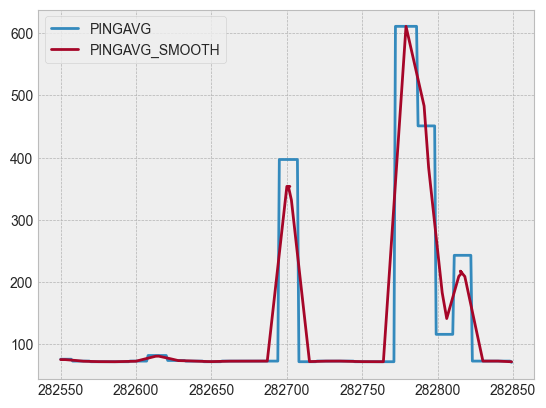

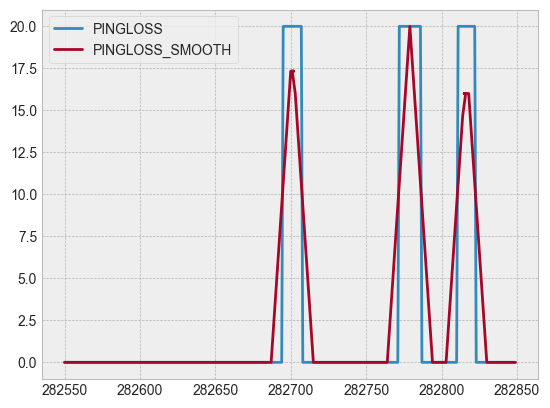

In [41]:
#example of how rolling average affects the values
df_trace_182 = df_5g[df_5g['TraceID']==182]
df_trace_182=df_trace_182.iloc[2300:2600]
df_trace_182=df_trace_182.sort_values(by='Timestamp', ascending = False)
df_trace_182[['PINGAVG', 'PINGAVG_SMOOTH']].plot(label='PINGAVG_SMOOTH vs PINGAVG')
df_trace_182[['PINGLOSS', 'PINGLOSS_SMOOTH']].plot(label='PINGLOSS_SMOOTH vs PINGLOSS')

In [53]:
#if any timestamp of a trace is duplicated (ussually ping info), drop it
print(len(df_5g))
df_5g = df_5g.drop_duplicates(subset=['Timestamp'])
print(len(df_5g))

#leave only rows when downloading
df_5g = df_5g[df_5g['State']=='D']

#ensure download speed is atleast 50kb
df_5g['DL_bitrate'] = df_5g['DL_bitrate'].clip(lower=50)

#keep only 1 decimal place
pd.options.display.float_format = '{:,.1f}'.format
#PING to int
df_5g['PINGAVG_SMOOTH'] = df_5g['PINGAVG_SMOOTH'].astype(int)

26720
26720


In [54]:
df_5g

,Timestamp,DL_bitrate,PINGAVG,PINGLOSS,State,download_type,trace_mobility,TraceID,NetworkMode,PINGAVG_SMOOTH,PINGLOSS_SMOOTH
247282,2019.12.14_10.18.05,14908,82.0,0.0,D,download,car,164,5G,82,0.0
247283,2019.12.14_10.18.06,9877,82.0,0.0,D,download,car,164,5G,82,0.0
247284,2019.12.14_10.18.07,10116,82.0,0.0,D,download,car,164,5G,82,0.0
247285,2019.12.14_10.18.09,11466,82.0,0.0,D,download,car,164,5G,82,0.0
247286,2019.12.14_10.18.10,14350,84.0,0.0,D,download,car,164,5G,83,0.0
...,...,...,...,...,...,...,...,...,...,...,...
274245,2020.02.27_20.41.15,13986,138.0,0.0,D,download,car,179,5G,131,0.0
274246,2020.02.27_20.41.16,12577,138.0,0.0,D,download,car,179,5G,128,0.0
274247,2020.02.27_20.41.17,2873,138.0,0.0,D,download,car,179,5G,125,0.0
274248,2020.02.27_20.41.19,2178,138.0,0.0,D,download,car,179,5G,122,0.0


In [63]:
#sort traces by timestamp
df_5g=df_5g.sort_values(by='Timestamp', ascending = True)


#df_5g_final = df_5g[['DL_bitrate', 'PINGAVG_SMOOTH', 'PINGLOSS_SMOOTH']]

#save traces to separate files
grouped = df_5g.groupby(by=['TraceID', 'trace_mobility'])
for name, group in grouped:
    trace, mobil = name
    #keep only important columns
    group.to_csv(f"processed/{mobil}_{trace}.csv", index=False,
                 columns=['DL_bitrate', 'PINGAVG_SMOOTH', 'PINGLOSS_SMOOTH'], float_format='%.1f')

In [64]:
pd.read_csv('processed/car_179.csv')

,DL_bitrate,PINGAVG_SMOOTH,PINGLOSS_SMOOTH
0,207,93,9.3
1,50,91,8.0
2,50,90,6.7
3,50,87,4.0
4,50,85,2.7
...,...,...,...
278,13986,131,0.0
279,12577,128,0.0
280,2873,125,0.0
281,2178,122,0.0


In [67]:
grouped = df_5g.groupby(by=['TraceID', 'trace_mobility']).agg({'DL_bitrate':'median'})
grouped

,,DL_bitrate
TraceID,trace_mobility,
164,car,"11,466.0"
165,car,"14,774.5"
167,car,"16,603.0"
168,car,"32,250.0"
169,car,"13,769.0"
170,car,"13,479.5"
171,car,"21,284.0"
172,car,"123,578.0"
173,car,"8,312.0"


Dropping rows with null values would be the normal choice for most types of data, but that does not work for time series data. It is important there are no large gaps of nan values in the traces. Therefore traces with a certain number of nan values are removed

In [25]:
test = df_5g
#get count of nans per trace
nan_counts = test[test.isna().any(axis=1)]['TraceID'].value_counts().rename('Nan') 

#get total number of values per trace
full_counts = test['TraceID'].value_counts().rename('All values') 
nan_traces = nan_counts.to_frame().join(full_counts)

#get ratio between nans and all values
nan_traces['NaN Ratio'] = nan_traces['Nan']/nan_traces['All values'] 
nan_traces

,Nan,All values,NaN Ratio
164,9,524,0.017176
184,4,5991,0.000668


In [13]:
#get list of traces that have more than 15% null values
to_remove = nan_traces[nan_traces['NaN Ratio'] > 0.15].index.to_series() 
df_5g = df_5g[~df_5g['TraceID'].isin(to_remove)] #drop traces
to_remove.index

Index([116, 115,  26, 160,   5,  56,  17,  45,  32,  24, 155,  36, 117, 149,
        47, 133,  27,  63, 128,  50,  51, 123, 140, 153, 145,  23, 124, 131,
       119,  73,  49, 177,  25, 152, 178, 174, 125, 173, 132, 126,  48, 154,
       118,  35,  21,  22, 179, 206,  61,  20, 129,  43, 120, 164, 130, 166,
       134, 137,  44, 146, 122, 167,   1, 141,  12,   2, 121, 151,  66,   3],
      dtype='Int64')

In [14]:
df_5g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242068 entries, 0 to 363233
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Timestamp       242068 non-null  string 
 1   Speed           242068 non-null  Int64  
 2   CellID          242068 non-null  Int64  
 3   NetworkMode     242068 non-null  string 
 4   RSRP            242068 non-null  Int64  
 5   RSRQ            241728 non-null  float64
 6   SNR             239509 non-null  float64
 7   CQI             239509 non-null  float64
 8   DL_bitrate      242068 non-null  Int64  
 9   State           242068 non-null  string 
 10  download_type   242068 non-null  string 
 11  trace_mobility  242068 non-null  string 
 12  TraceID         242068 non-null  Int64  
dtypes: Int64(5), float64(3), string(5)
memory usage: 27.0 MB


In total 12 columns will be used for the enviroment definition. The most important metric is DL_bitrate, determining the current speed of downloading a file. RSRP, RSRQ, SNR, CQI are signal strength measures.

## Trace distribution analysis

In [15]:
df_5g.describe()

,Speed,CellID,RSRP,RSRQ,SNR,CQI,DL_bitrate,TraceID
count,242068.0,242068.0,242068.0,241728.000000,239509.000000,239509.000000,242068.0,242068.0
mean,14.031871,743.886891,-93.665796,-12.396065,3.892522,9.956215,12786.894257,137.817944
std,19.63554,5145.19031,12.04815,2.964713,7.415986,3.185371,32025.803638,61.963252
min,0.0,0.0,-200.0,-26.000000,-30.000000,0.000000,0.0,0.0
25%,0.0,2.0,-101.0,-14.000000,-1.000000,8.000000,0.0,84.0
50%,2.0,11.0,-96.0,-13.000000,3.000000,10.000000,1767.0,158.0
75%,27.0,11.0,-87.0,-11.000000,8.000000,12.000000,12056.0,191.0
max,115.0,64262.0,-27.0,4.000000,35.000000,15.000000,532905.0,217.0


Text(0.5, 1.0, 'Download bitrate distribution')

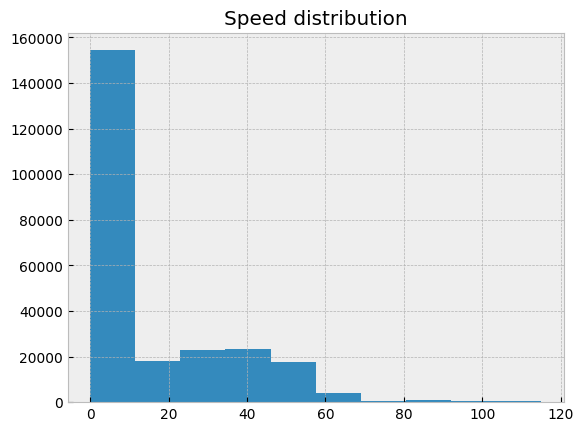

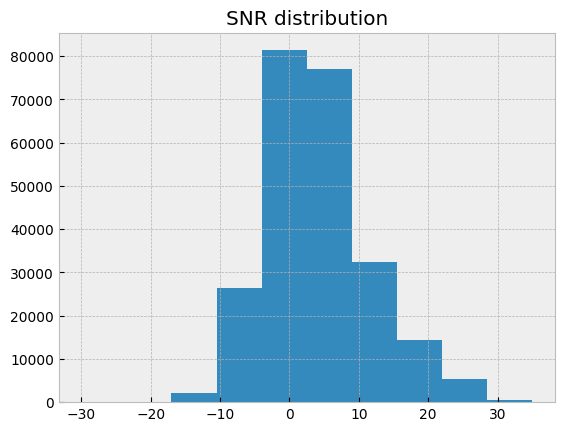

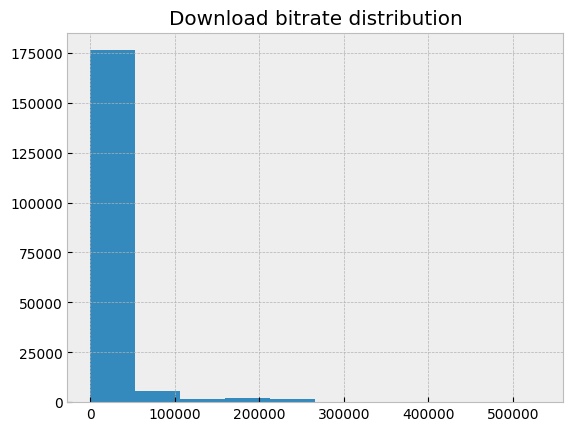

In [16]:
df_5g[['Speed']].hist(bins=10)
plt.title("Speed distribution")
df_5g[['SNR']].hist(bins=10)
plt.title("SNR distribution")

#for bitrate distribution, only times when there is a download in progress are used
df_5g[df_5g['State']=='D'][['DL_bitrate']].hist(bins=10)
plt.title("Download bitrate distribution")

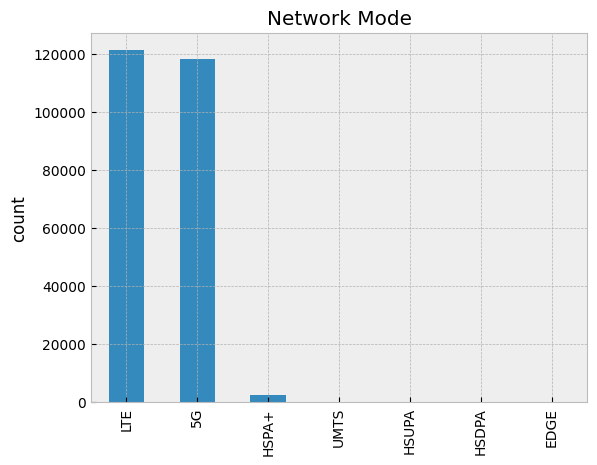

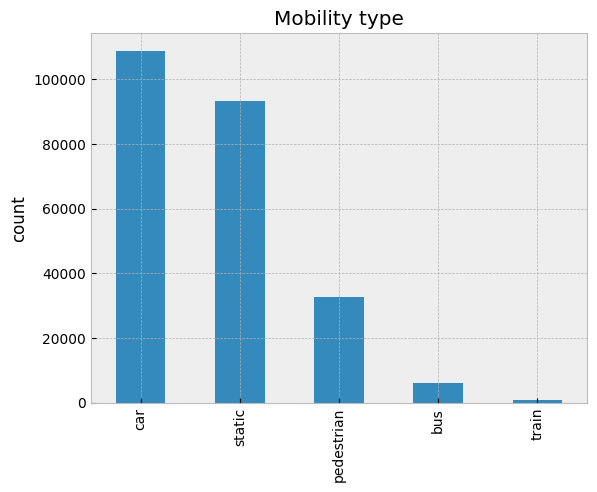

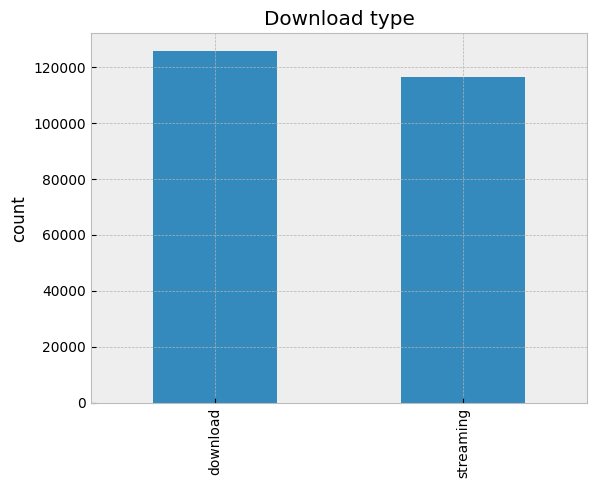

count          148.0
mean     1635.594595
std      1301.792688
min            268.0
25%            764.0
50%           1257.0
75%           1983.5
max           7190.0
Name: Number of Samples per trace, dtype: Float64

In [17]:
df_5g['NetworkMode'].value_counts().plot(kind='bar', ylabel='count', title='Network Mode')
plt.show()
df_5g['trace_mobility'].value_counts().plot(kind='bar', ylabel='count', title='Mobility type')
plt.show()
df_5g['download_type'].value_counts().plot(kind='bar', ylabel='count', title='Download type')
plt.show()
df_5g['TraceID'].value_counts().rename("Number of Samples per trace").describe()

Most data is well balanced across features, but there is some HSPA+ connections. This represents a connection with 3g when 4g is not available.
Also, due to null value dropping most traces with HSPA+ were removed, as that connection did not seem to support most measurements that are needed.

## Trace parameter covariance analysis
A covariance analysis is performed to indentify how well does the data align to real world assumptions. The main related factors in the dataset are SNR and bitrate, as in wireless networks a low SNR causes packet loss and thus reduced bandwith.

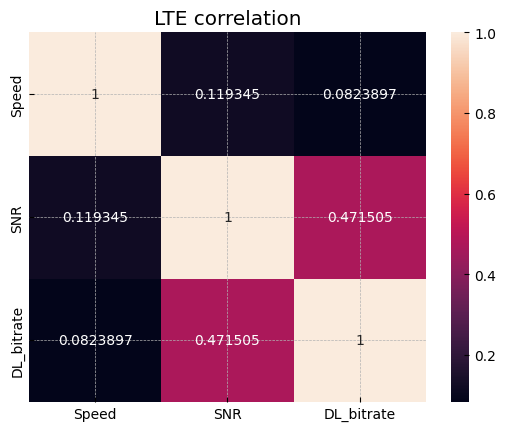

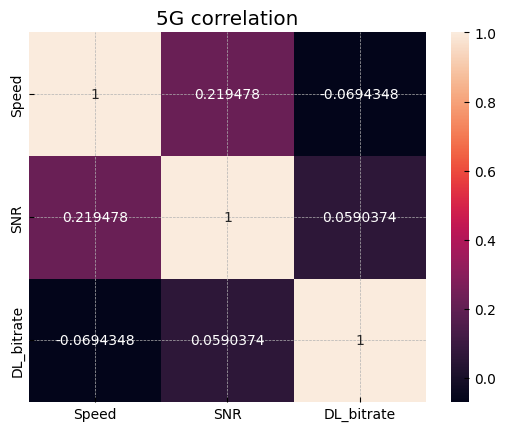

In [18]:
#again for bitrate only times when there is a download in progress are used
analysis_df = df_5g[df_5g['State']=='D']
cov_matrix = analysis_df[analysis_df['NetworkMode'] == 'LTE'][['Speed', 'SNR', 'DL_bitrate']].corr()
sns.heatmap(cov_matrix, annot=True, fmt='g')
plt.title("LTE correlation")
plt.show()

cov_matrix = analysis_df[analysis_df['NetworkMode'] == '5G'][['Speed', 'SNR', 'DL_bitrate']].corr()
sns.heatmap(cov_matrix, annot=True, fmt='g')
plt.title("5G correlation")
plt.show()

There are a few medium correlations present, one of them being Signal to Noise Ratio(SNR) with download bitrate, which is expected given that signal strength influences dropped packets and such max throughput.
There are differences between 5g and LTE, which is expected due to these being fundamentally different technologies.

## Analysis of max througput


In [19]:
file_down = df_5g[df_5g['State']=='D'] # select traces when downloading only

#get 95th and 5th quantile, mean of download bitrate for each trace
file_down_grouped = file_down.groupby(['TraceID', 'NetworkMode', 'trace_mobility'])
    .agg({'DL_bitrate': [ 'mean', lambda x: x.quantile(0.95), lambda x: x.quantile(0.05),]})
file_down_grouped.columns = ['mean', 'q95', 'q05']
file_down_grouped = file_down_grouped.reset_index()
file_down_grouped

,TraceID,NetworkMode,trace_mobility,mean,q95,q05
0,0,LTE,bus,13617.584989,38291.00,246.00
1,4,LTE,bus,11043.767241,31410.75,861.00
2,6,LTE,bus,7417.774336,21364.10,358.65
3,7,LTE,bus,12204.923636,32575.80,1200.95
4,8,LTE,bus,23896.412331,63397.20,722.70
...,...,...,...,...,...,...
241,215,5G,static,2356.538536,20272.35,0.00
242,215,LTE,static,4961.96,17014.10,0.00
243,216,5G,static,2459.094358,18679.40,0.00
244,216,LTE,static,3425.888889,13927.60,2.00


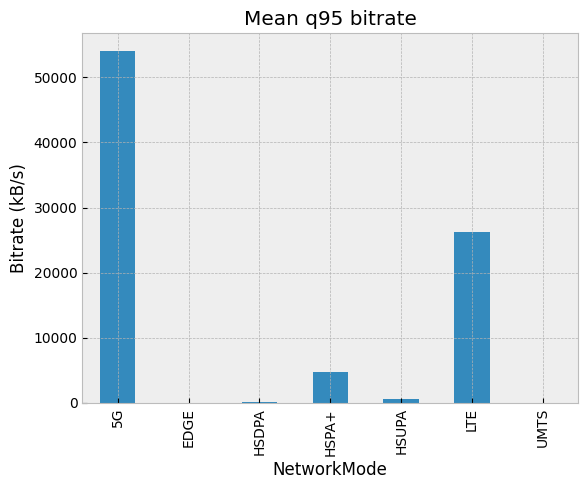

In [20]:
file_down_grouped.groupby(['NetworkMode'])['q95'].mean()
    .plot(kind='bar', ylabel='Bitrate (kB/s)', title='Mean q95 bitrate')
plt.show()

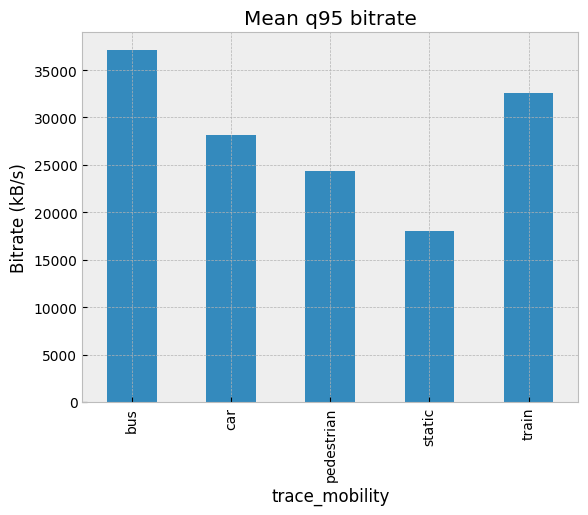

In [21]:
file_down_grouped[file_down_grouped['NetworkMode']=='LTE'].groupby(['trace_mobility'])['q95']
    .mean().plot(kind='bar', ylabel='Bitrate (kB/s)', title='Mean q95 bitrate')
plt.show()